In [1]:
%load_ext autoreload
%autoreload 2
from utils.utils import *
from utils.utils_train import *
from utils.utils_imports import *

In [2]:
# Load SBERT Embeddings
queries, query_embeddings, product_embeddings = load_raw_queries()

# load ids_toys from disk
with open('output/ids_toys.pkl', 'rb') as file:
    ids_toys = pickle.load(file)
    print(f"len(ids_toys): {len(ids_toys)}")
    ids_present = [_id for _id in ids_toys if _id in query_embeddings]

# Assemble qb & xb input embeddings
qb = torch.stack([torch.tensor(query_embeddings[_id]) for _id in ids_present])
xb = torch.tensor(np.array([product_embeddings[_id] for _id in ids_present]))

# Split Dataset into Train and Test
(qb_train, qb_test), (xb_train, xb_test), (idx_train, idx_test) = shuffle_and_split(qb, xb, split=0.8, seed=12)
print(f'len(qb_train): {len(qb_train)}')
print(f'len(qb_test): {len(qb_train)}')

# Two-Tower Pytorch Model
d = hidden_dim = qb_train.shape[-1]
list_recall3 = []
list_test_epochs = []

# Initialize the network
model = TwoTowerNetwork(d, hidden_dim) 


loaded (queries, query_embeddings, product_embeddings) from  output/raw_queries.pkl
len(ids_toys): 84373
len(qb_train): 20560
len(qb_test): 20560
dropout         : 0.1
learning_rate   : 0.001
label_smoothing : 0.35
batch_size      : 1024
eval_iter       : 1

TwoTowerNetwork(
  (qb_tower): Sequential(
    (0): Linear(in_features=768, out_features=768, bias=False)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=768, out_features=768, bias=False)
    (4): Dropout(p=0.1, inplace=False)
  )
  (xb_tower): Sequential(
    (0): Linear(in_features=768, out_features=768, bias=False)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=768, out_features=768, bias=False)
    (4): Dropout(p=0.1, inplace=False)
  )
)
num_params:2.36 million 


epoch 29.650, train_loss: 3.5947
epoch 29.700, train_loss: 3.5966
epoch 29.750, train_loss: 3.5898
epoch 29.800, train_loss: 3.6061
epoch 29.850, train_loss: 3.5902
epoch 29.900, train_loss: 3.5927
epoch 29.950, train_loss: 3.5985
epoch 30.000, train_loss: 3.5878
epoch 30.050, train_loss: 3.5821
epoch 30.100, train_loss: 3.5864
epoch 30.150, train_loss: 3.5851
epoch 30.200, train_loss: 3.5894
epoch 30.250, train_loss: 3.5867
epoch 30.300, train_loss: 3.5807
epoch 30.350, train_loss: 3.6055
epoch 30.400, train_loss: 3.5791
epoch 30.450, train_loss: 3.5909
epoch 30.500, train_loss: 3.5975
epoch 30.550, train_loss: 3.5877
epoch 30.600, train_loss: 3.5952
recall@3 = 0.697                    
epoch 30.650, train_loss: 3.5826
epoch 30.700, train_loss: 3.5766
epoch 30.750, train_loss: 3.5768
epoch 30.800, train_loss: 3.5748
epoch 30.850, train_loss: 3.5687
epoch 30.900, train_loss: 3.5827
epoch 30.950, train_loss: 3.5609
epoch 31.000, train_loss: 3.5804
epoch 31.050, train_loss: 3.5694
epoch 

/Users/ozkansafak/code/retrieval/utils/utils_train.py:97: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  [(ax.set_xlim(0,len(list_test_epochs)), ax.set_ylim(0)) for ax in [ax1, ax2]]


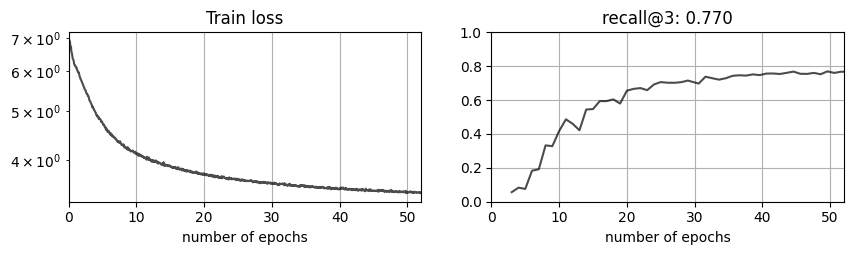

epoch 54.650, train_loss: 3.4261
epoch 54.700, train_loss: 3.4346
epoch 54.750, train_loss: 3.4308
epoch 54.800, train_loss: 3.4267
epoch 54.850, train_loss: 3.4307
epoch 54.900, train_loss: 3.4376
epoch 54.950, train_loss: 3.4335
epoch 55.000, train_loss: 3.4377
epoch 55.050, train_loss: 3.4243
epoch 55.100, train_loss: 3.4364
epoch 55.150, train_loss: 3.4332
epoch 55.200, train_loss: 3.4333
epoch 55.250, train_loss: 3.4302
epoch 55.300, train_loss: 3.4257
epoch 55.350, train_loss: 3.4271
epoch 55.400, train_loss: 3.4396
epoch 55.450, train_loss: 3.4373
epoch 55.500, train_loss: 3.4334
epoch 55.550, train_loss: 3.4343
epoch 55.600, train_loss: 3.4252
recall@3 = 0.755                    
epoch 55.650, train_loss: 3.4342
epoch 55.700, train_loss: 3.4197
epoch 55.750, train_loss: 3.4227
epoch 55.800, train_loss: 3.4253
epoch 55.850, train_loss: 3.4373
epoch 55.900, train_loss: 3.4252
epoch 55.950, train_loss: 3.4281
epoch 56.000, train_loss: 3.4373
epoch 56.050, train_loss: 3.4239
epoch 

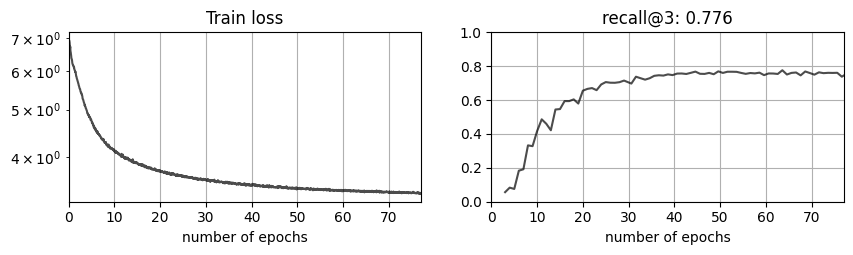

epoch 79.650, train_loss: 3.3646
epoch 79.700, train_loss: 3.3689
epoch 79.750, train_loss: 3.3681
epoch 79.800, train_loss: 3.3631
epoch 79.850, train_loss: 3.3599
epoch 79.900, train_loss: 3.3712
epoch 79.950, train_loss: 3.3630
epoch 80.000, train_loss: 3.3694
epoch 80.050, train_loss: 3.3722
epoch 80.100, train_loss: 3.3673
epoch 80.150, train_loss: 3.3689
epoch 80.200, train_loss: 3.3680
epoch 80.250, train_loss: 3.3757
epoch 80.300, train_loss: 3.3673
epoch 80.350, train_loss: 3.3707
epoch 80.400, train_loss: 3.3679
epoch 80.450, train_loss: 3.3665
epoch 80.500, train_loss: 3.3672
epoch 80.550, train_loss: 3.3801
epoch 80.600, train_loss: 3.3733
recall@3 = 0.762                    
epoch 80.650, train_loss: 3.3573
epoch 80.700, train_loss: 3.3767
epoch 80.750, train_loss: 3.3721
epoch 80.800, train_loss: 3.3641
epoch 80.850, train_loss: 3.3653
epoch 80.900, train_loss: 3.3628
epoch 80.950, train_loss: 3.3710
epoch 81.000, train_loss: 3.3694
epoch 81.050, train_loss: 3.3720
epoch 

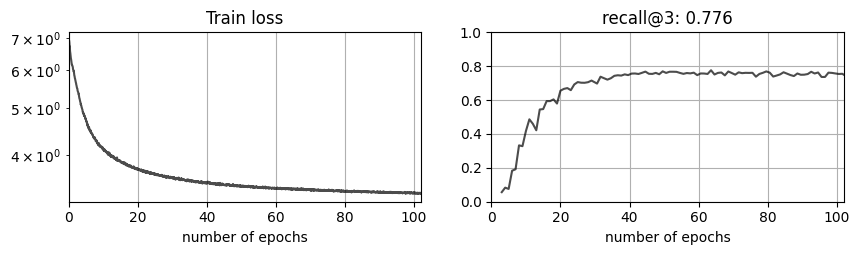

epoch 104.650, train_loss: 3.3316
epoch 104.700, train_loss: 3.3234
epoch 104.750, train_loss: 3.3408
epoch 104.800, train_loss: 3.3329
epoch 104.850, train_loss: 3.3310
epoch 104.900, train_loss: 3.3344
epoch 104.950, train_loss: 3.3337
epoch 105.000, train_loss: 3.3335
epoch 105.050, train_loss: 3.3427
epoch 105.100, train_loss: 3.3328
epoch 105.150, train_loss: 3.3307
epoch 105.200, train_loss: 3.3411
epoch 105.250, train_loss: 3.3311
epoch 105.300, train_loss: 3.3390
epoch 105.350, train_loss: 3.3416
epoch 105.400, train_loss: 3.3255
epoch 105.450, train_loss: 3.3353
epoch 105.500, train_loss: 3.3331
epoch 105.550, train_loss: 3.3334
epoch 105.600, train_loss: 3.3322
recall@3 = 0.753                    
epoch 105.650, train_loss: 3.3391
epoch 105.700, train_loss: 3.3333
epoch 105.750, train_loss: 3.3322
epoch 105.800, train_loss: 3.3216
epoch 105.850, train_loss: 3.3290
epoch 105.900, train_loss: 3.3265
epoch 105.950, train_loss: 3.3217
epoch 106.000, train_loss: 3.3319
epoch 106.0

KeyboardInterrupt: 

In [6]:
%%time
## TRAIN

for i in range(200):
    # reshuffle the trainset at beginning of each epoch
    (qb_train, _), (xb_train, _), (_) = shuffle_and_split(qb_train, xb_train, split=1)

    # train for 1 epoch
    model.fit(qb_train, xb_train)

    # write output embeddings to use for eval
    write_output_embeddings(model, qb_test, xb_test) 

    # run eval
    os.system('cd utils && python3 utils_infer.py')

    # read recall@3 metric written to json file
    with open('output/recall3.json', 'r') as file:
        recall3 = json.load(file)['recall3']

    # monitor metrics to plot recall.
    list_test_epochs.append(model.epochs[-1])
    list_recall3.append(recall3) 

    if (i+1) % 25 == 0:
        model.plot(qb_train, list_test_epochs, list_recall3) 

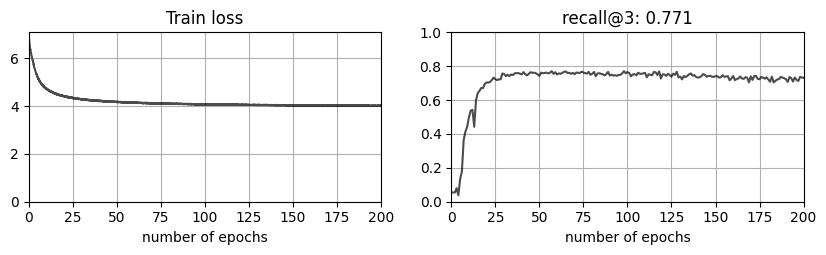

In [4]:
model.plot(qb_train, list_test_epochs, list_recall3)


In [ ]:
# TODO:
# 1. Incorporate a learning_rate scheduler
# 2. print the top 3 results for hits. 
# 3. naive baseline on SBERT embeddings recall@3 = 0.745
# 4. 

In [10]:
write_output_embeddings(model, qb_test, xb_test) 
os.system('cd utils && python3 utils_infer.py')


### The End

In [ ]:
# Load queries, ids_toys, ids_present
with open('output/raw_queries.pkl', 'rb') as file:
    queries, _, _ = pickle.load(file)

with open('output/ids_toys.pkl', 'rb') as file:
    ids_toys = pickle.load(file)
    ids_present = [_id for _id in ids_toys if _id in query_embeddings]


In [5]:
top_ids = [ids_present[idx_test[i]] for i in I[0]]
names = [info[_id]['name'] for _id in top_ids]
details = [info[_id]['details'] for _id in top_ids]
description = [info[_id]['description'] for _id in top_ids]
queries[ids_present[idx_test[0]]]

"I need to buy a Super-duper Tutu/Cape/Mask set in size 4-6 for my 4-6-year-old. It's a 3-piece set perfect for little Superheroines and Rock Stars!"